In [1]:
from generate_data import wave_util
from generate_data import wave_propagation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = '14'

In [2]:
# set up models
import torch
from models import model_tiramisu
from models import model_unet

#unet model setup
unet_model = model_unet.UNet(depth=6, wf=1, acti_func='relu', scale_factor=2)
unet_model.load_state_dict(torch.load('../results/run_1/saved_model_unet128_9b.pt'))
unet_model.eval()
unet_model = unet_model.double()

#tiramisu model setup
tir_model = model_tiramisu.FCDenseNet(scale_factor=4)
tir_model = torch.nn.DataParallel(tir_model)
tir_model.load_state_dict(torch.load('../results/run_1/saved_model_tiramisu256_1.pt'))
tir_model.eval()
tir_model = tir_model.double()

netlist = [
    (r'unet 3lvl', unet_model),
    (r'tiramisu 55-55', tir_model)
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

unet 3lvl number of trainable parameters 2560008
tiramisu 55-55 number of trainable parameters 691283


In [7]:
# parameter setup

Tf = 2.0
cT = 0.2
dx = 1.0/128.0 #1.0/128.0  # -> 256
dt = dx / 20
Ny, Nx = 256, 256
ny, nx = 64, 64
m = 4 #2
rt = 4
mt = round(Tf/cT)
t = np.linspace(0,Tf,mt)
xx, yy = np.meshgrid(np.linspace(-1, 1, Nx), np.linspace(-1, 1, Ny))

np.random.seed = 21
center_1 = np.array([-.4,-.4])
u0_1 = np.exp(-250.0*(0.2*(xx-center_1[0])**2 + (yy-center_1[1])**2))*np.cos(8*np.pi*(yy-center_1[1]))
center_2 = np.array([.4,.4])
u0_2 = np.exp(-250.0*(0.2*(xx-center_2[0])**2 + (yy-center_2[1])**2))*np.cos(8*np.pi*(yy-center_2[1]))
u0 = u0_2 + u0_1
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
vel = 1. + 0.0*yy #- 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) #np.ones([np.size(xx,axis=1),np.size(yy,axis=0)]) #fig9 vel

veltest = (
   ('refrac',vel),
)

In [8]:
for velname, vel in veltest:

    #### Fine solution ####
    uf = np.zeros([xx.shape[0],xx.shape[1],mt])
    utf = np.zeros([xx.shape[0],xx.shape[1],mt])
    uf[:,:,0] = u0
    utf[:,:,0] = ut0
    for j in range(1,mt):
        uf[:,:,j],utf[:,:,j] = wave_propagation.velocity_verlet(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,cT)

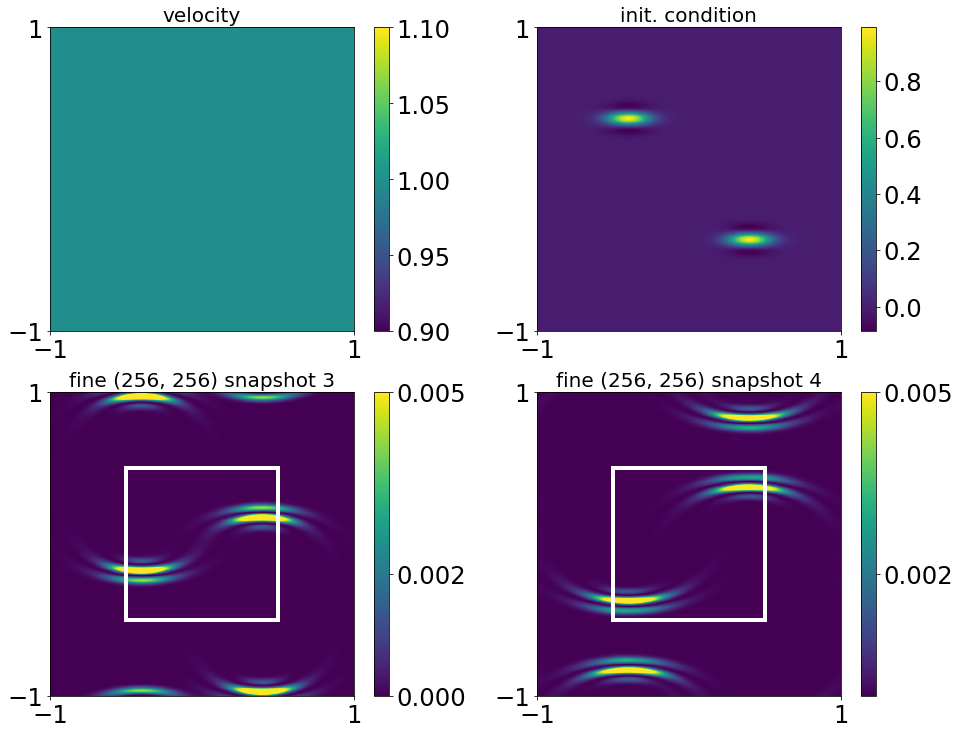

In [9]:
tj = 4
fig1 = plt.figure(figsize=(16,19))

ax1 = fig1.add_subplot(3,2,1)
pos1 = ax1.imshow(vel,extent=(-1,1,-1,1))
ax1.set_title('velocity', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos1)

ax2 = fig1.add_subplot(3,2,2)
pos2 = ax2.imshow(u0,extent=(-1,1,-1,1))
ax2.set_title('init. condition', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos2)

ax3 = fig1.add_subplot(3,2,3)
pos3 = ax3.imshow(wave_util.WaveEnergyField(uf[:,:,tj-1],utf[:,:,tj-1],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax3.set_title('fine ' + str(uf[:,:,tj].shape) + " snapshot 3", fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([.5,.5],[.5,-.5],'w',linewidth=4)
plt.plot([-.5,-.5],[-.5,.5],'w',linewidth=4)
plt.plot([-.5,.5],[.5,.5],'w',linewidth=4)
plt.plot([.5,-.5],[-.5,-.5],'w',linewidth=4)
plt.colorbar(pos3,ticks = [0,0.002,0.005])

ax4 = fig1.add_subplot(3,2,4)
pos4 = ax4.imshow(wave_util.WaveEnergyField(uf[:,:,tj],utf[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax4.set_title('fine ' + str(uf[:,:,tj].shape) + " snapshot 4", fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([.5,.5],[.5,-.5],'w',linewidth=4)
plt.plot([-.5,-.5],[-.5,.5],'w',linewidth=4)
plt.plot([-.5,.5],[.5,.5],'w',linewidth=4)
plt.plot([.5,-.5],[-.5,-.5],'w',linewidth=4)
plt.colorbar(pos4,ticks = [0,0.002,0.005])